In [1]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.4.1


In [2]:
batch_size = 32
seq_len = 240 #1 day has 8 data points. 30 days data got 240 data points

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

model_name = 'Transformer_ETH_Norm.hdf5'

Training data shape: (11360, 5)
Validation data shape: (1420, 5)
Test data shape: (1420, 5)


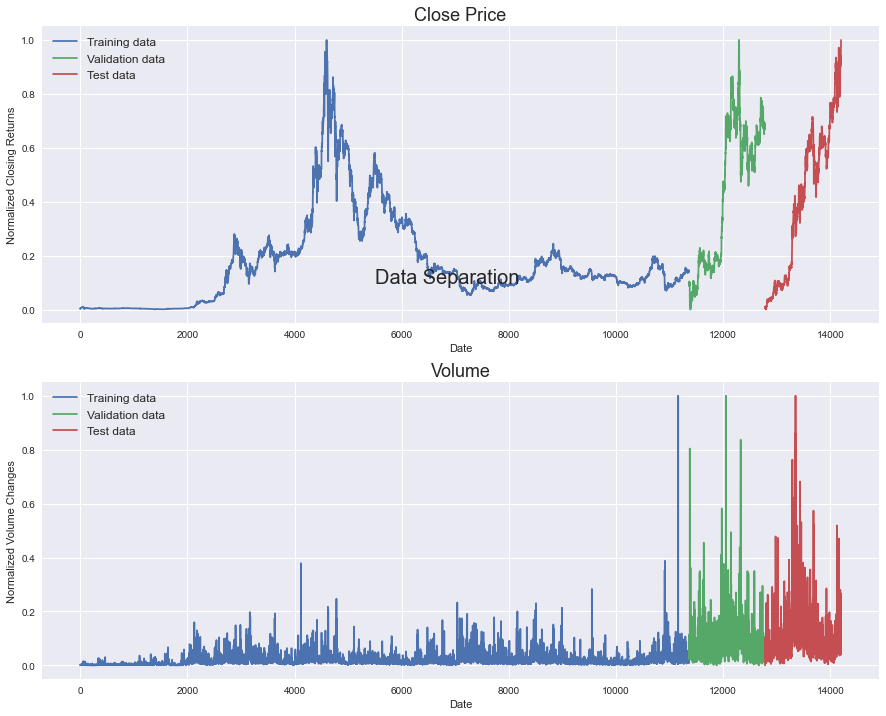

In [11]:
eth_path = './Data/ETH_3rs_History_20150101_20210427.csv'
from DataProcessingAndPlotting import preprocess_train_test_val, plot_train_val_test
df_train, train_data, df_val, val_data, df_test, test_data = preprocess_train_test_val(data_path=eth_path, normalization=True)
plot_train_val_test(train_data, df_train, val_data, df_val, test_data, df_test)

In [12]:
from DataProcessingAndPlotting import preprocess_train_val_test_Xy
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_train_val_test_Xy(train_data, val_data, test_data)

Training set shape (11120, 240, 5) (11120,)
Validation set shape (1180, 240, 5) (1180,)
Testing set shape (1180, 240, 5) (1180,)


In [ ]:
from Time2Vector import Time2Vector
from Transformer import TransformerEncoder, SingleAttention, MultiAttention

def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    
    '''Construct model'''
    in_seq = tf.keras.Input(shape=(seq_len, 5))
    x = time_embedding(in_seq)
    x = tf.keras.layers.Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    out = tf.keras.layers.Dense(1, activation='linear')(x)

    model = tf.keras.Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model
    
model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

In [ ]:
from Transformer import TransformerEncoder, SingleAttention, MultiAttention
model = tf.keras.models.load_model(model_name,
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

In [ ]:
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

In [ ]:
from DataProcessingAndPlotting import plot_result
plot_result(train_data, train_pred, val_data, val_pred, test_data, test_pred, 'eth_norm_pred_vs_reality.png')

In [ ]:
from DataProcessingAndPlotting import plot_history
plot_history(
    history=history,
    fig_name='eth_norm_history_loss.png'
)

In [2]:
from sagemaker.tensorflow import TensorFlow